<a href="https://colab.research.google.com/github/ShaitoMo/-Disease-detection-from-Chest-X-Ray/blob/main/Chest-X-Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project: Disease detection from Chest X-Ray**
#Mohammad Shaito    


# 🧠 Project Goal:

Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

## Project Steps:

*   **Data Exploration:** Understand the structure, content, and characteristics of the chest X-ray dataset.
*   **Data Preprocessing:** Prepare the image data for model training, including tasks like resizing, normalization, and augmentation.
*   **Model Building:** Design and implement a deep learning model architecture suitable for image classification.
*   **Evaluation:** Assess the performance of the trained model using appropriate metrics and visualize the results.

# Data Exploration

- Import the Dataset
- Load the chest X-ray dataset into the notebook.  
- Check basic details: number of images, file structure, and labels.  

In [19]:
#import the libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files
import zipfile




In [ ]:
#uploading using kaggle API
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# upload kaggle.json


with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:59<00:00, 43.3MB/s]
100% 2.29G/2.29G [01:00<00:00, 40.8MB/s]


In [26]:
#splitting the content
base_dir = '/content/chest_xray/'
train_dir = base_dir + 'train/'
val_dir = base_dir + 'val/'
test_dir = base_dir + 'test/'


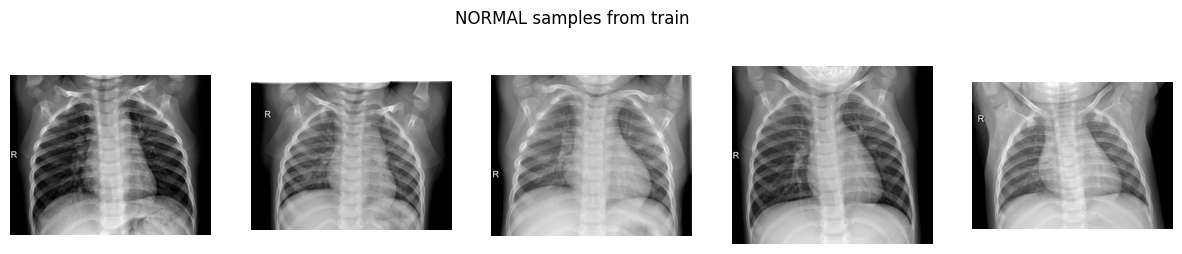

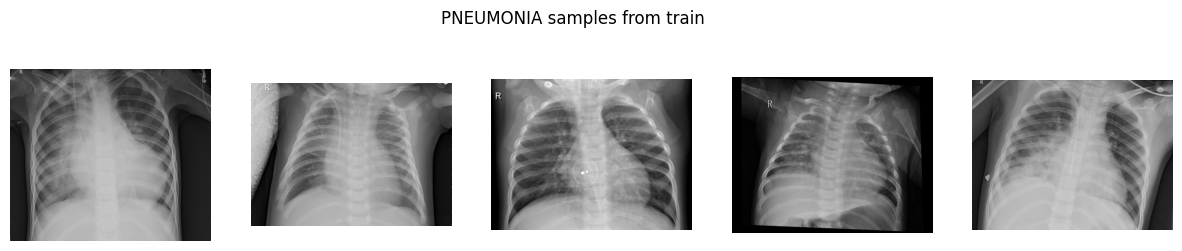

In [ ]:


def plot_samples(folder, category):

    path = os.path.join(base_dir, folder, category)
    sample_images = os.listdir(path)[:5]  # take first 5 images
    plt.figure(figsize=(15,3))
    for i, img_file in enumerate(sample_images):
        img = tf.keras.preprocessing.image.load_img(os.path.join(path,img_file))
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'{category} samples from {folder}')
    plt.show()

# Plot samples from training set
plot_samples('train', 'NORMAL')
plot_samples('train', 'PNEUMONIA')

In [ ]:

# Function to count images per class
def class_distribution(folder):
    normal_count = len(os.listdir(os.path.join(base_dir, folder, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(base_dir, folder, 'PNEUMONIA')))
    print(f"{folder.upper()} set:")
    print(f"  NORMAL: {normal_count}")
    print(f"  PNEUMONIA: {pneumonia_count}")
    print("-" * 30)

# Check distribution in train, val, and test sets
for folder in ['train', 'val', 'test']:
    class_distribution(folder)


TRAIN set:
  NORMAL: 1341
  PNEUMONIA: 3875
------------------------------
VAL set:
  NORMAL: 8
  PNEUMONIA: 8
------------------------------
TEST set:
  NORMAL: 234
  PNEUMONIA: 390
------------------------------


## 🛠️ Data Processing

To prepare the dataset for training, we applied several preprocessing techniques:

- **Resizing**: All images are resized to `224x224` to match the MobileNetV2 input size.  
- **Normalization**: Pixel values are rescaled to `[0,1]` for stable training.  
- **Data Augmentation**: Applied random transformations to increase data variability and reduce overfitting:
  - Random rotations  
  - Horizontal flips  
  - Zooming  
  - Shifts (width/height)  

These augmentations help the model generalize better by simulating real-world variations in chest X-ray images.


In [ ]:

#  augmentation + normalization

train_datagen = ImageDataGenerator(
    rescale=1./255,             # normalize pixel values (0-1)
    rotation_range=20,           # randomly rotate images
    zoom_range=0.15,             # random zoom
    width_shift_range=0.2,       # horizontal shift
    height_shift_range=0.2,      # vertical shift
    shear_range=0.15,            # shear transformation
    horizontal_flip=True,        # random horizontal flip
    fill_mode='nearest'          # fill empty pixels
)

In [ ]:
# 2 Validation & Test data: only normalization

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train/',
   target_size=(224, 224),   # Resize all images
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/chest_xray/test/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Building  

We use **MobileNetV2** as the base model through transfer learning.  
The choice of MobileNetV2 is mainly due to **hardware and Colab limitations** (it is lightweight and efficient),  
but it still provides **strong feature extraction** for image classification tasks.  

We freeze the base model initially to leverage the pretrained ImageNet weights,  
then add custom layers (GlobalAveragePooling, BatchNormalization, Dense, Dropout)  
to adapt the model for our binary classification problem (Normal vs. Pneumonia).  


In [ ]:

y_train = train_generator.classes  # 0 for NORMAL, 1 for PNEUMONIA

# Compute balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [ ]:
# Model definition (transfer learning approach)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization() ,
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile with binary crossentropy for binary classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# The model will be saved by the ModelCheckpoint callback during training.
# You can load it after training using the cell below this one.
# best_model = load_model("best_model.h5")
# test_loss, test_acc = best_model.evaluate(test_generator, verbose=2)
# print(f"\nBest Model Test Accuracy: {test_acc:.4f}")
# print(f"Best Model Test Loss: {test_loss:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8658 - loss: 0.2853

163/163 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.8660 - loss: 0.2849 - val_accuracy: 0.7500 - val_loss: 0.4006
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9415 - loss: 0.1455

163/163 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9414 - loss: 0.1455 - val_accuracy: 0.9375 - val_loss: 0.1709
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9408 - loss: 0.1451

163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.9408 - loss: 0.1451 - val_accuracy: 1.0000 - val_loss: 0.0834
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9443 - loss: 0.1336 - val_accuracy: 0.8750 - val_loss: 0.3721
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9375 - loss: 0.1394 - val_accuracy: 0.8750 - val_loss: 0.2134
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9494 - loss: 0.1247 - val_accuracy: 0.9375 - val_loss: 0.1668
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9542 - loss: 0.1189 - val_accuracy: 1.0000 - val_loss: 0.0922
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9466 - loss: 0.1297 - val_accuracy: 0.8750 - val_loss: 0.1753


## Evaluation  

To assess the performance of the trained model, we use multiple evaluation metrics:  

- **Accuracy**: Overall percentage of correct predictions.  
- **Precision**: Of all predicted Pneumonia cases, how many are correct.  
- **Recall (Sensitivity)**: Of all actual Pneumonia cases, how many are correctly detected.  
- **F1-score**: Harmonic mean of Precision and Recall (better for imbalanced data).  

We also generate a **Confusion Matrix** to visualize classification performance across classes.  

Finally, we plot **training vs validation accuracy and loss curves** to analyze the learning behavior of the model and check for underfitting or overfitting.  


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.h5")
test_loss, test_acc = best_model.evaluate(test_generator, verbose=2)
print(f"\nBest Model Test Accuracy: {test_acc:.4f}")
print(f"Best Model Test Loss: {test_loss:.4f}")


20/20 - 32s - 2s/step - accuracy: 0.8878 - loss: 0.2734

Best Model Test Accuracy: 0.8878
Best Model Test Loss: 0.2734


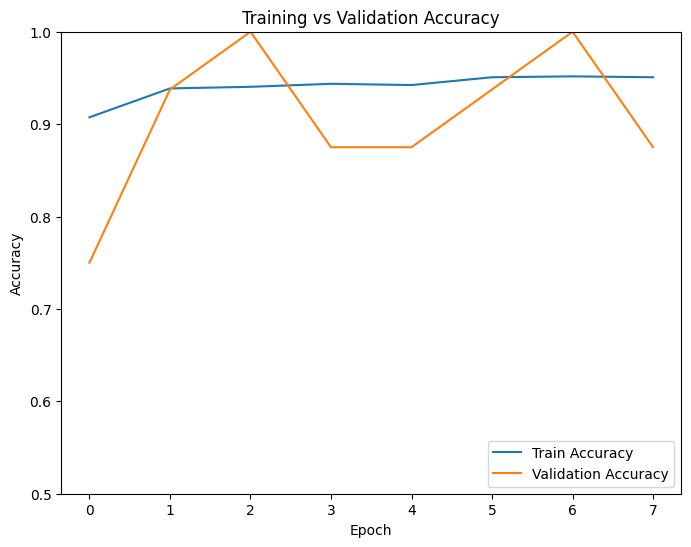

20/20 - 28s - 1s/step - accuracy: 0.8878 - loss: 0.2734

Test Accuracy: 0.8878
Test Loss: 0.2734


In [ ]:

# Plot training vs validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')
plt.show()

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


In [20]:
y_pred_probs = best_model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step

Accuracy: 0.8878
Precision: 0.9167
Recall: 0.9026
F1-score: 0.9096


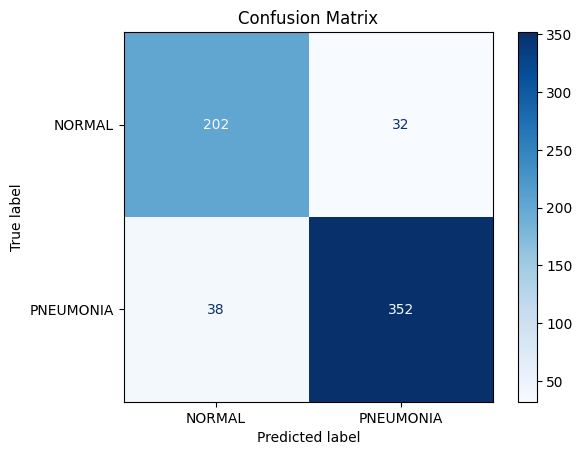

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


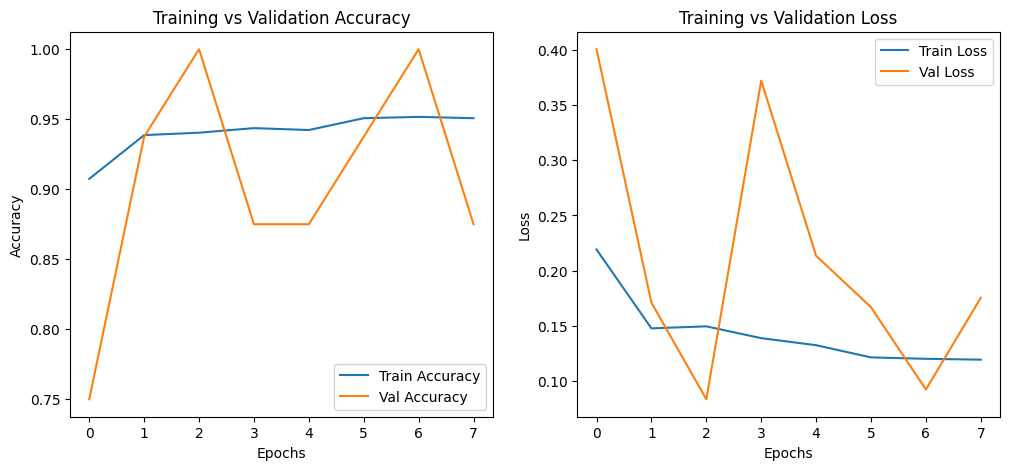

In [25]:
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

# ## Conclusion 🩺💻

# We built a pneumonia detection model using chest X-rays and MobileNetV2.
# Data was preprocessed with resizing, normalization, and augmentation.

# ✅ Test Accuracy: 89%
# ⚡ Metrics: Precision, Recall, F1-score
# 🔍 Confusion matrix shows some misclassifications remain.

# Transfer learning helped achieve good results with limited data & hardware.
# Future work: try different architectures, fine-tune layers, expand dataset.

# Deep learning shows promise for aiding medical diagnosis. 🚑
